<a href="https://colab.research.google.com/github/r2klabs/CS430Repository/blob/main/DecisionTrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree Classification




In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Imports for Decision Trees


In [19]:
from sklearn import tree
from sklearn.tree import export_text

## Imports for Splitting Data and Building Pipeline


In [20]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

In [21]:
from sklearn import set_config
set_config(display='diagram')

# Imports for Performance Measures

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error


## Confusion Matrix Function
This function is for creating a graphical version of the confusion matrix.



In [23]:
def plot_cm(y_test, y_pred):
    cm = confusion_matrix(y_test,y_pred)
    fig = plt.figure(figsize=(10,10))
    heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='RdYlGn')
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')

The function below plots a straight line on a plot.


In [24]:
def abline(slope, intercept,color):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', c=color)

# Decision Tree Classifier

### Information Entropy
$$ H(X) = -\sum_{i=1}^{k}p(x_i)log_{b}p(x_i)$$

* where k is the number of classes
* $p(x_i)$ is the probability of class i
* b is the base (usually base 2)

Basically entropy is the impurity of the collection of examples.   A system with all **data points of the same class** would have low entropy (minimum impurity) because if you always choose that class, you will be correct!  Weird, I know.

$$ H(X) = -\sum_{i=1}^{1}p(1)log_{2}p(1) = 0 $$



Suppose you have a data set with 2 classes like the data set below:

In [25]:
X = np.array([-3.5,-1.0, -5.2, -4.9, -3.6, 9.5, 3.8, 4.3, 9.7, 8.5])
y = np.array([-0.5, 2.4, 6.2, 3.3, 4.7, 5.1, 8.9, 9.7, -1.7, -2.9])
outcome = [1,1,1,1,0,0,0,0,0,0]
data = np.concatenate((X.reshape(10,1),y.reshape(10,1)), axis=1)
df = pd.DataFrame(data)
df.rename(columns={0:'x',1:'y'}, inplace=True)
df['outcome'] = outcome

In [26]:
df

,x,y,outcome
0,-3.5,-0.5,1
1,-1.0,2.4,1
2,-5.2,6.2,1
3,-4.9,3.3,1
4,-3.6,4.7,0
5,9.5,5.1,0
6,3.8,8.9,0
7,4.3,9.7,0
8,9.7,-1.7,0
9,8.5,-2.9,0


If we consider the entire data set, the entropy in the system is:

In [27]:
import math
entropy = -1*((0.4*math.log2(0.4))+(0.6*math.log2(0.6)))
print("Entropy of the whole system is: ", entropy)

Entropy of the whole system is:  0.9709505944546686


## Information Gain
The goal of decision trees is to determine where to split the data so that the entropy is **reduced**. In other words, we are trying to get as close to zero entropy as we can with our splits. Let's look at an example.

$$ G(S, A) = I(S) -\sum_{v\in Values(A)} \frac{|S_{v}|}{|S|}I(S) $$

What if we split the data at zero on the x-axis as shown in the figure below?

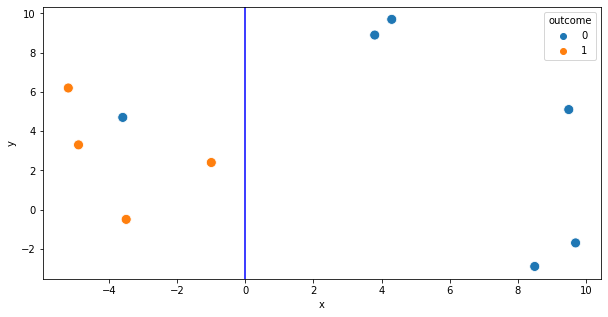

In [28]:
fig = plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='x', y='y', hue='outcome', s=100)
plt.axvline(x = 0.0, color = 'b')

The information gain would be calculated as:

$$ G(S, A) = I(S) -\sum_{v\in Values(A)} \frac{|S_{v}|}{|S|}I(S) $$

Using each branch of our split, we calculate the entropy for that branch.  Each branch only contains one class.

In [29]:
left = -1*(0.2*math.log2(0.2)+0.8*math.log2(0.8))
right = -1*(1.0*math.log2(1.0))
esplit = .5 * left + .5 * right
print(esplit)

0.36096404744368116


In [30]:
information_gain = entropy - esplit
print("Information gain is: ", information_gain)

Information gain is:  0.6099865470109874


What if we split the data at four on the x-axis as shown in the figure below?

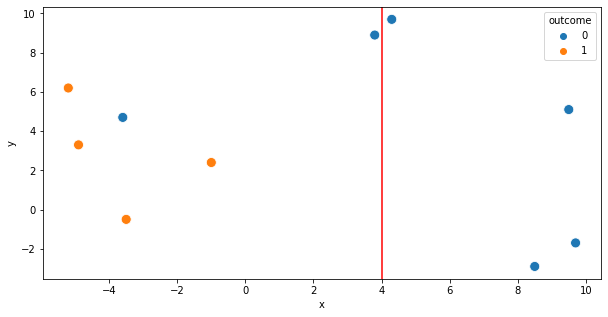

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='x', y='y', hue='outcome', s=100)
plt.axvline(x = 4, color = 'red')

In [31]:
left = -1*((2/3)*math.log2((2/3))+(1/3)*math.log2((1/3)))
right = -1*(1.0*math.log2(1.0))
esplit = .6 * left + .4 * right
print(esplit)

0.5509775004326937


In [32]:
information_gain = entropy - esplit
print("Information gain is: ", information_gain)

Information gain is:  0.4199730940219749


The second split is better because it **reduces the entropy** of the system. In this example, we only had two classes, but in a decision tree the splits are based on different columns and the process continues.

## Acquire Data

In [33]:
df = pd.read_csv('/content/gdrive/MyDrive/CS430/original_census.csv')

In [34]:
df.head()

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,39,state_gov,77516,bachelors,never_married,adm_clerical,not_in_family,white,male,2174,0,40,united_states,<=50K
1,50,self_emp_not_inc,83311,bachelors,married_civ_spouse,exec_managerial,husband,white,male,0,0,13,united_states,<=50K
2,38,private,215646,hs_grad,divorced,handlers_cleaners,not_in_family,white,male,0,0,40,united_states,<=50K
3,53,private,234721,11th,married_civ_spouse,handlers_cleaners,husband,black,male,0,0,40,united_states,<=50K
4,28,private,338409,bachelors,married_civ_spouse,prof_specialty,wife,black,female,0,0,40,cuba,<=50K


### Statistical and Visual Exploration

In [35]:
df.describe()

,age,fnlwgt,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,99999.000000,4356.000000,99.000000


In [36]:
df.query('hours_per_week>40')

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
7,52,self_emp_not_inc,209642,hs_grad,married_civ_spouse,exec_managerial,husband,white,male,0,0,45,united_states,>50K
8,31,private,45781,masters,never_married,prof_specialty,not_in_family,white,female,14084,0,50,united_states,>50K
10,37,private,280464,some_college,married_civ_spouse,exec_managerial,husband,black,male,0,0,80,united_states,>50K
13,32,private,205019,assoc_acdm,never_married,sales,not_in_family,black,male,0,0,50,united_states,<=50K
15,34,private,245487,7th_8th,married_civ_spouse,transport_moving,husband,amer_indian_eskimo,male,0,0,45,mexico,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32538,38,private,139180,bachelors,divorced,prof_specialty,unmarried,black,female,15020,0,45,united_states,>50K
32543,45,local_gov,119199,assoc_acdm,divorced,prof_specialty,unmarried,white,female,0,0,48,united_states,<=50K
32548,65,self_emp_not_inc,99359,prof_school,never_married,prof_specialty,not_in_family,white,male,1086,0,60,united_states,<=50K
32550,43,self_emp_not_inc,27242,some_college,married_civ_spouse,craft_repair,husband,white,male,0,0,50,united_states,<=50K


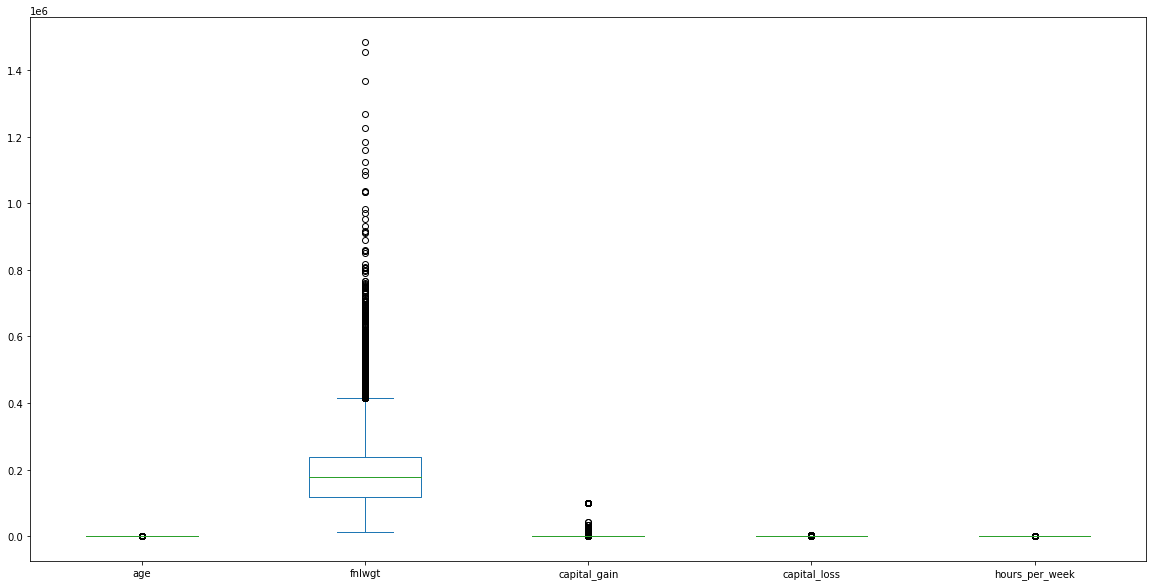

In [37]:
df.plot(kind='box',figsize=(20,10))

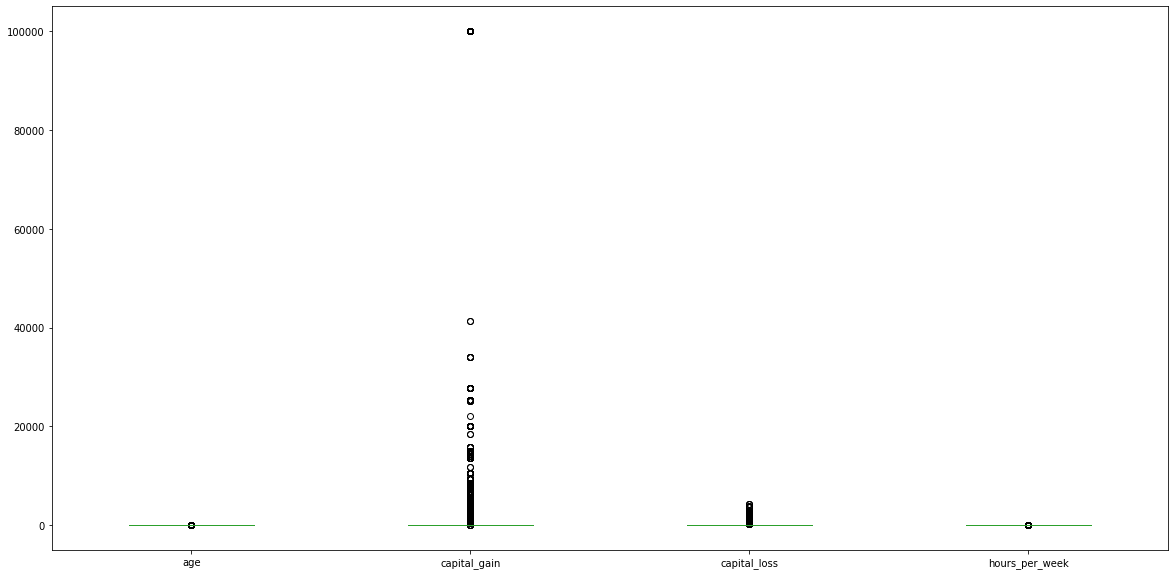

In [39]:
df[['age','capital_gain','capital_loss','hours_per_week']].plot(kind='box',figsize=(20,10))

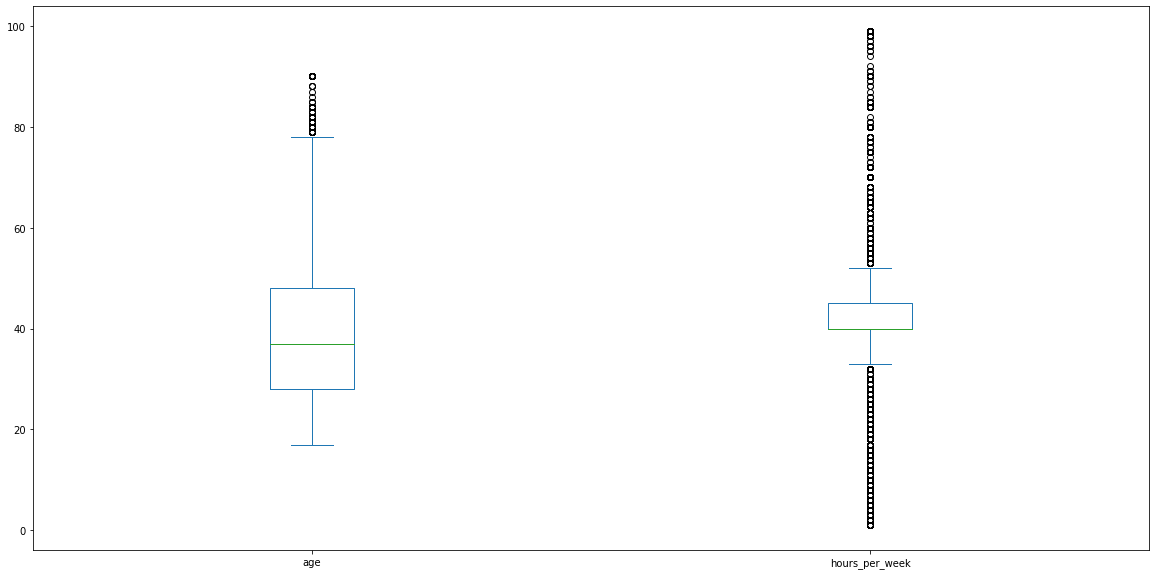

In [40]:
df[['age','hours_per_week']].plot(kind='box',figsize=(20,10))

In [41]:
salary =df.salary.groupby(df.salary).count()

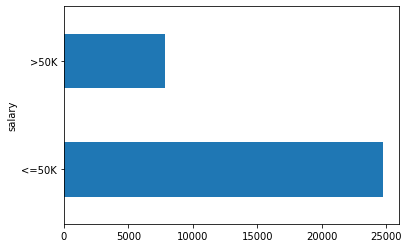

In [42]:
salary.plot(kind='barh')

In [43]:
plotDF = df[['age','fnlwgt','capital_gain','capital_loss','hours_per_week', 'salary']]

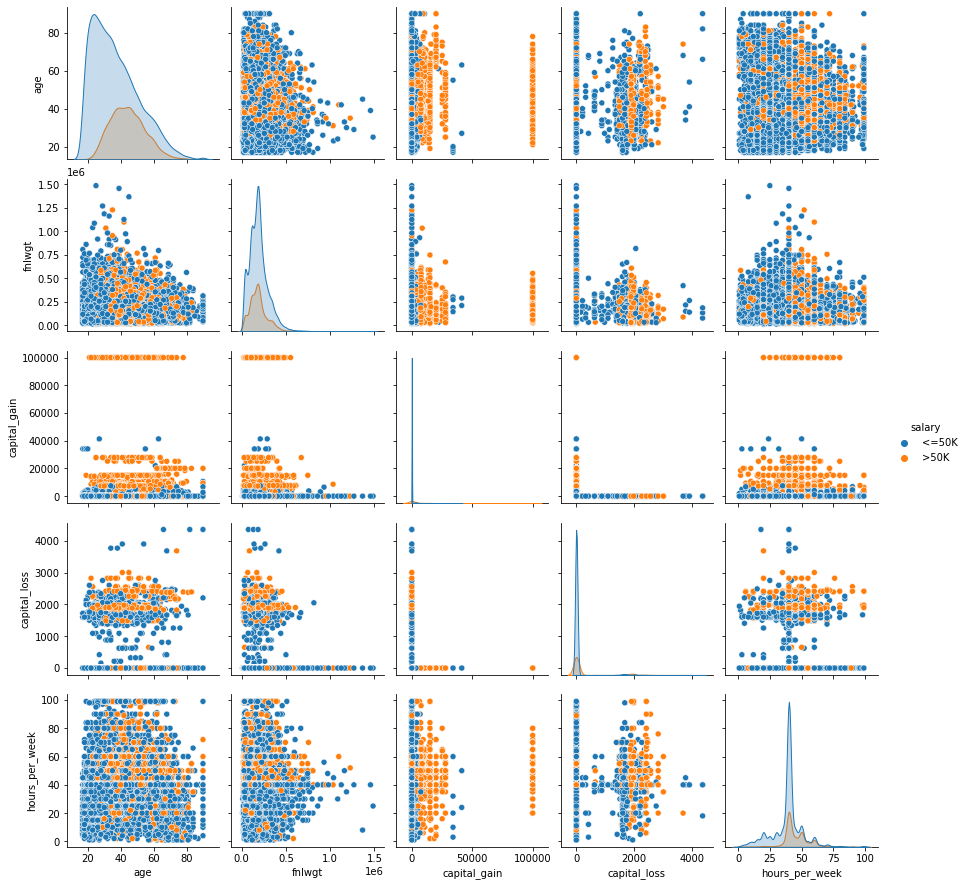

In [ ]:
sns.pairplot(data=plotDF, diag_kind='kde', hue='salary')

### Splitting Data into Train/Test

In [44]:
df['salary'].replace("<=50K", 0, inplace=True)
df['salary'].replace(">50K", 1, inplace=True)

In [46]:
df.sample(10)

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
590,42,unknown,137390,hs_grad,married_civ_spouse,unknown,husband,white,male,0,0,40,united_states,0
19519,56,private,178202,some_college,married_civ_spouse,machine_op_inspct,husband,white,male,0,0,40,united_states,0
27044,32,private,164197,bachelors,married_civ_spouse,craft_repair,husband,white,male,0,0,44,united_states,1
11803,41,local_gov,176716,hs_grad,married_civ_spouse,transport_moving,husband,white,male,0,0,60,united_states,0
23437,18,private,25837,11th,never_married,prof_specialty,own_child,white,male,0,0,15,united_states,0
22762,31,private,196791,prof_school,divorced,prof_specialty,not_in_family,white,female,0,0,45,united_states,1
27249,28,private,51961,some_college,never_married,tech_support,own_child,black,male,0,0,24,united_states,0
6659,46,private,276087,hs_grad,married_civ_spouse,sales,husband,white,male,5013,0,50,united_states,0
1881,42,private,102606,bachelors,married_civ_spouse,tech_support,husband,white,male,0,0,40,united_states,1
21972,70,private,221603,some_college,widowed,sales,not_in_family,white,female,0,0,34,united_states,0


In [47]:
X = df.iloc[:,0:-1]
y = df[['salary']]

### Building the Pipeline
The pipeline here will be a little different than what we have done in the past.  This is because of the categorical values. If we OneHotEncode them after we split into train and test, we might have a different number of columns between train and test because the split could result in some values not appearing in test or vice versa. 

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.20, random_state=24)

We'll set up our lists to contain the columns that numerical vs categorical.

In [49]:
num_attribs = ['age','fnlwgt','capital_gain','capital_loss', 'hours_per_week']
cat_attribs = ['workclass','education','marital_status','occupation','relationship','race','sex','native_country']

Pandas has a function for OneHotEncoding you could use to apply to a dataframe. Here I am going to apply that transformation and the show some comparisons.

In [52]:
myDf = pd.get_dummies(X, columns=cat_attribs)

In [54]:
X_train = pd.get_dummies(X_train, columns=cat_attribs)
X_test = pd.get_dummies(X_test, columns=cat_attribs)

In [55]:
X_train.head()

,age,fnlwgt,capital_gain,capital_loss,hours_per_week,workclass_federal_gov,workclass_local_gov,workclass_never_worked,workclass_private,workclass_self_emp_inc,...,native_country_puerto_rico,native_country_scotland,native_country_south,native_country_taiwan,native_country_thailand,native_country_trinadad&tobago,native_country_united_states,native_country_unknown,native_country_vietnam,native_country_yugoslavia
20823,34,199934,0,0,40,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
21955,22,136873,0,0,40,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
688,41,195124,0,0,35,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
14876,29,161097,0,0,40,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
26491,35,112077,5013,0,40,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [56]:
print(len(X_train.columns))
print(len(X_test.columns))

107
105


Let's transform the categorical variables **before** we do the train/test split.

In [57]:
transformed_X = pd.get_dummies(X, columns=cat_attribs)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(transformed_X,y, test_size=.20, random_state=32)

In [59]:
print(len(X_train.columns))
print(len(X_test.columns))

107
107


Now we'll set up the column transformer to only minmax scale.  We are using remainder passthrough because we don't want to apply minmax to categorical variables.

In [60]:
col_transform = ColumnTransformer(transformers=[
                                 ('num',MinMaxScaler(), num_attribs)],
                                  remainder='passthrough')

In [61]:
pipeline = Pipeline([
                     ('transform', col_transform),
                     ('decision_tree',tree.DecisionTreeClassifier(max_depth=5))
                     ])

### Executing the Model

In [62]:
pipeline.fit(X_train,np.ravel(y_train))

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['age', 'fnlwgt',
                                                   'capital_gain',
                                                   'capital_loss',
                                                   'hours_per_week'])])),
                ('decision_tree', DecisionTreeClassifier(max_depth=5))])

### Evaluating Model

In [63]:
y_pred = pipeline.predict(X_test)

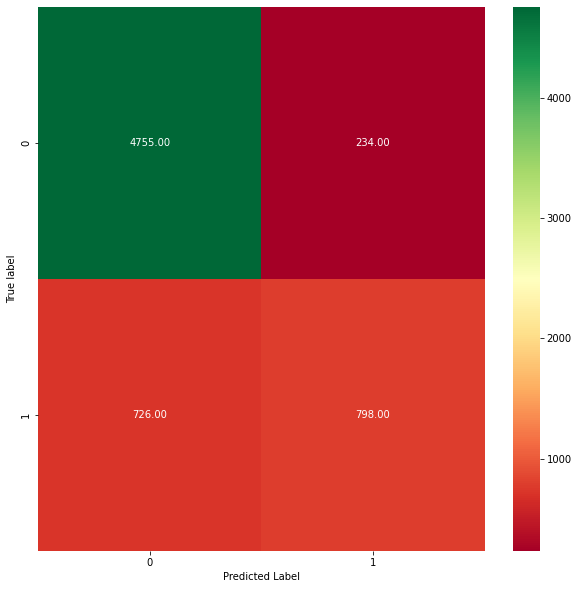

In [64]:
plot_cm(y_test,y_pred)

In [65]:
print("Precision: ", precision_score(y_test,y_pred))  
print("Recall:", recall_score(y_test,y_pred))
print("F1 Score:", f1_score(y_test,y_pred))

Precision:  0.7732558139534884
Recall: 0.5236220472440944
F1 Score: 0.624413145539906


### Conclusion
This model works isn't great with this data. I might need to try some of the different parameters to get a better model. Before we do that, let's try to visualize the tree.

[Text(0.5738636363636364, 0.9166666666666666, 'X[32] <= 0.5\nsamples = 26048\nvalue = [19731, 6317]'),
 Text(0.3068181818181818, 0.75, 'X[2] <= 0.071\nsamples = 14051\nvalue = [13113, 938]'),
 Text(0.18181818181818182, 0.5833333333333334, 'X[4] <= 0.444\nsamples = 13802\nvalue = [13103, 699]'),
 Text(0.09090909090909091, 0.4166666666666667, 'X[3] <= 0.543\nsamples = 11109\nvalue = [10800, 309]'),
 Text(0.045454545454545456, 0.25, 'X[46] <= 0.5\nsamples = 11092\nvalue = [10796, 296]'),
 Text(0.022727272727272728, 0.08333333333333333, 'samples = 9960\nvalue = [9773, 187]'),
 Text(0.06818181818181818, 0.08333333333333333, 'samples = 1132\nvalue = [1023, 109]'),
 Text(0.13636363636363635, 0.25, 'X[3] <= 0.768\nsamples = 17\nvalue = [4, 13]'),
 Text(0.11363636363636363, 0.08333333333333333, 'samples = 14\nvalue = [1, 13]'),
 Text(0.1590909090909091, 0.08333333333333333, 'samples = 3\nvalue = [3, 0]'),
 Text(0.2727272727272727, 0.4166666666666667, 'X[3] <= 0.549\nsamples = 2693\nvalue = [230

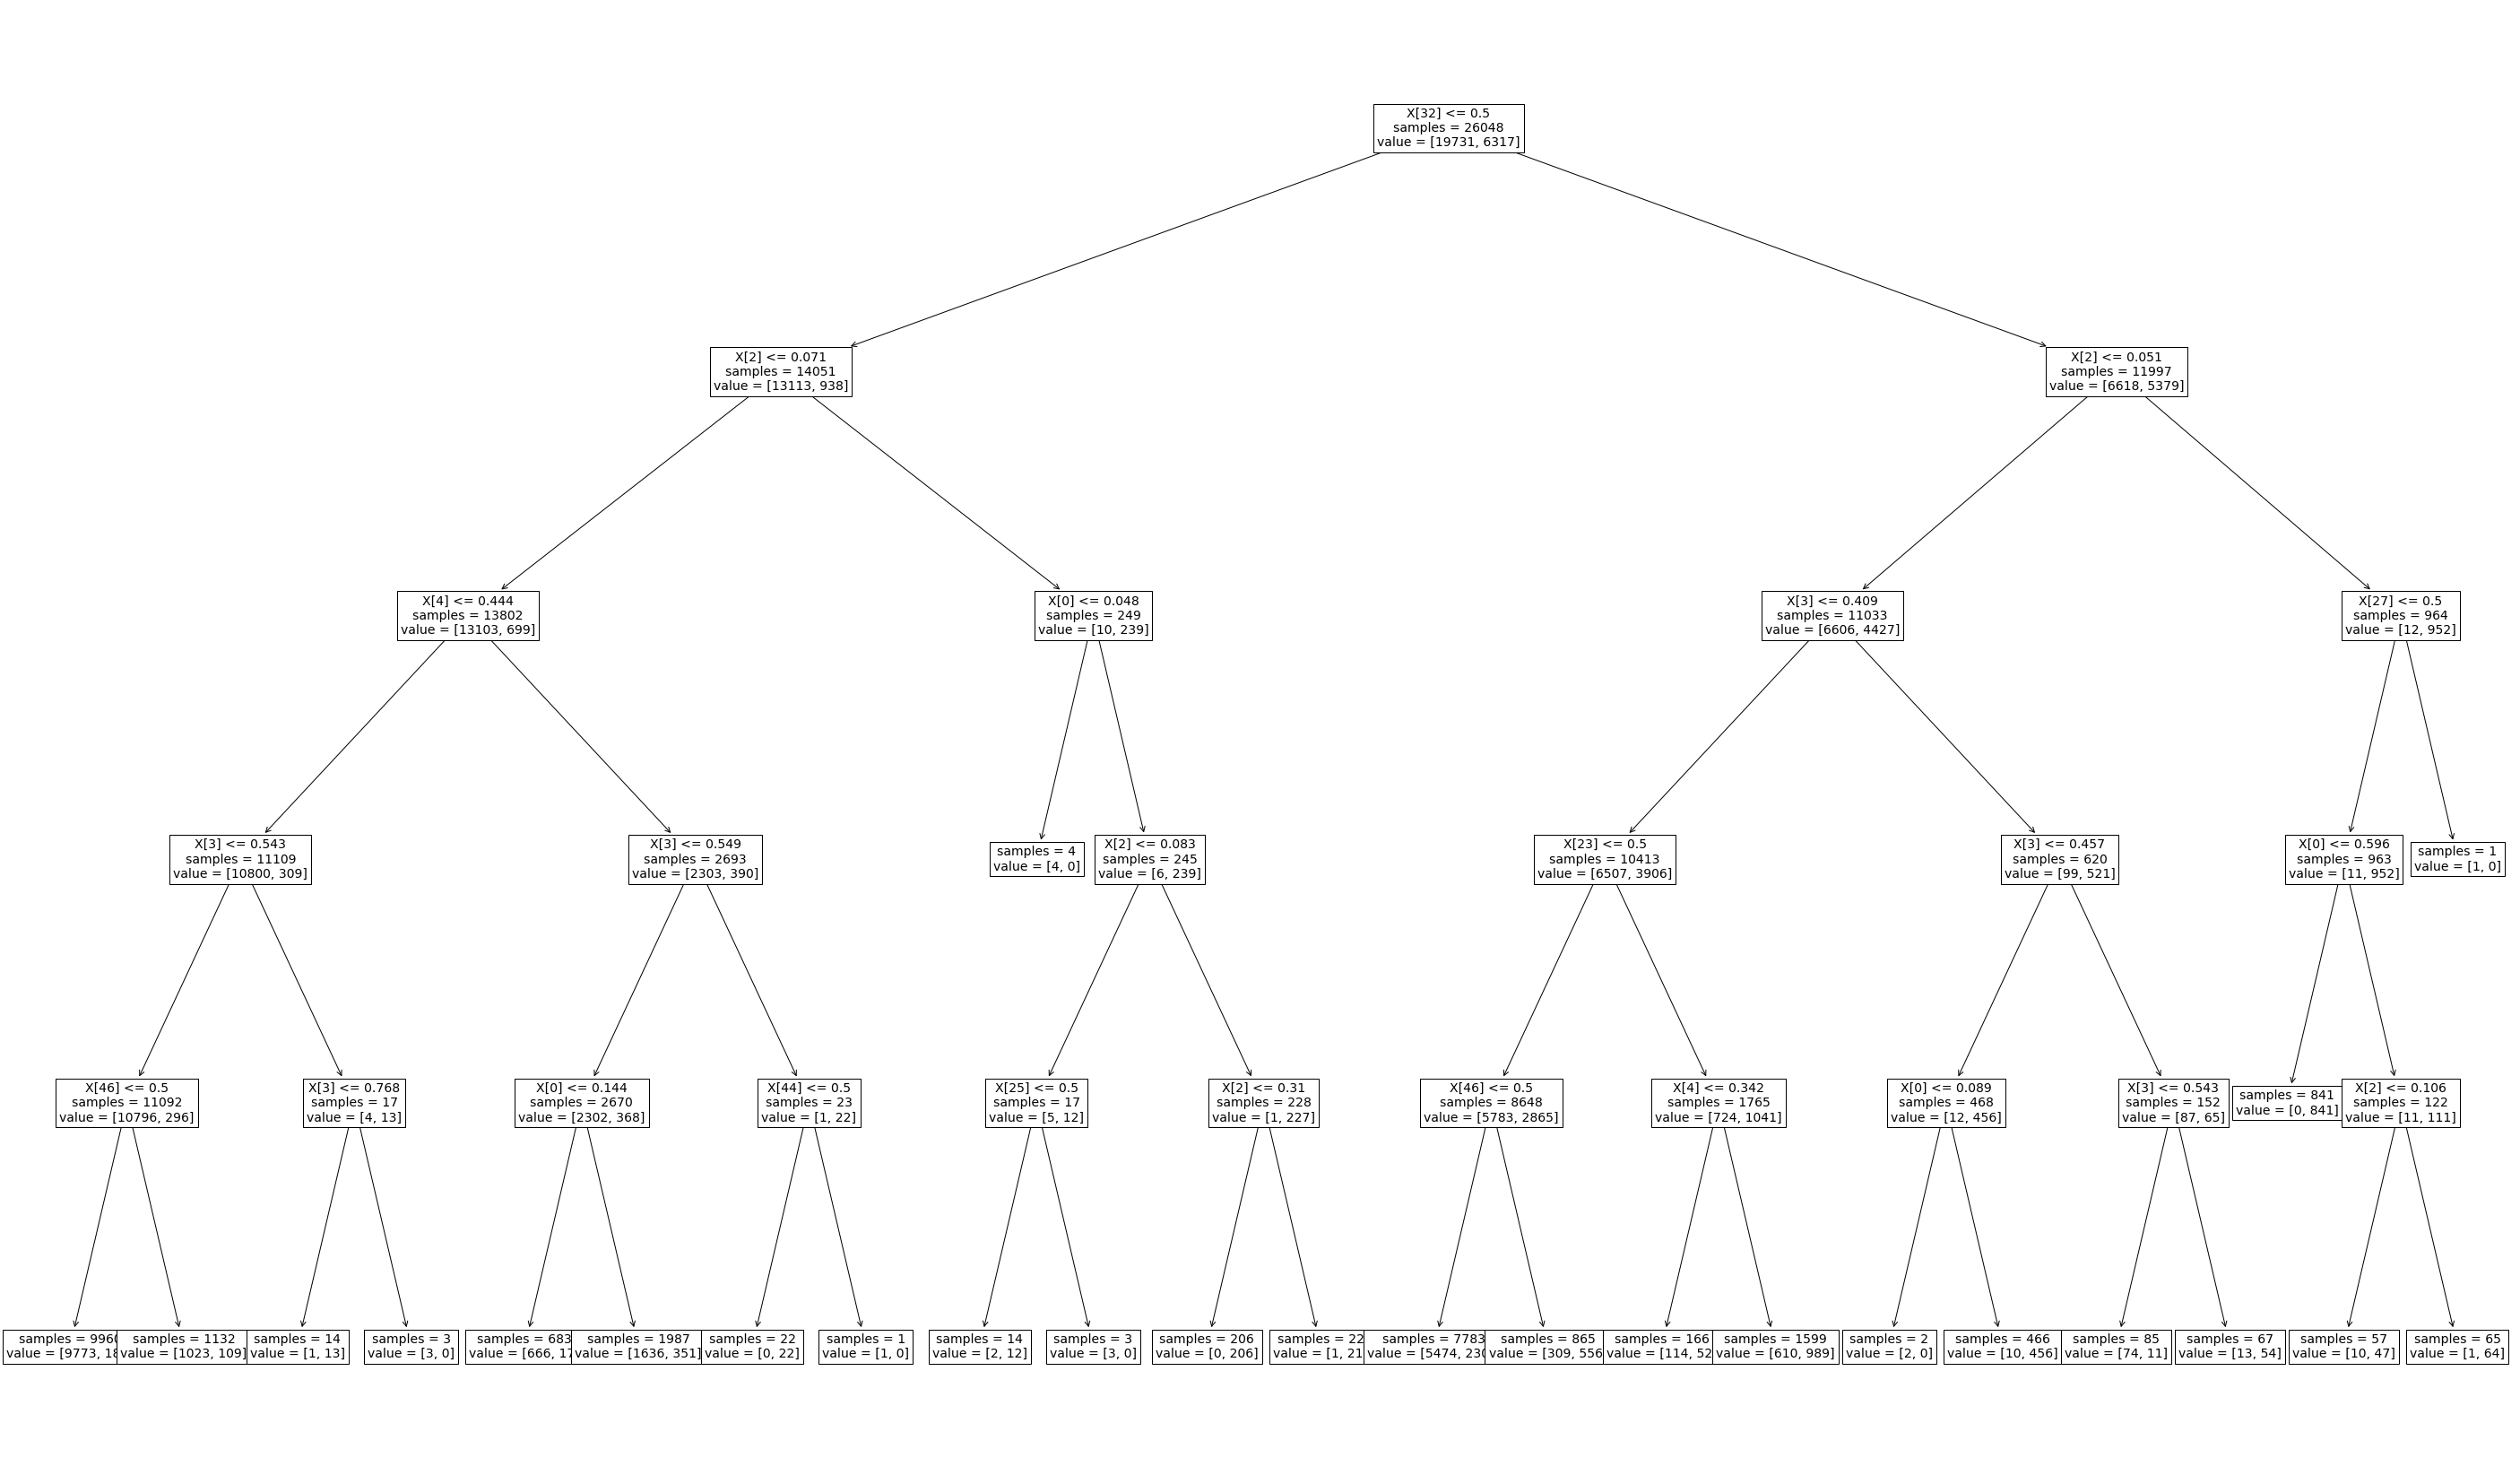

In [66]:
fig = plt.figure(figsize=(50,30))
tree.plot_tree(pipeline.named_steps.decision_tree, fontsize=14,impurity=False)

Now, let's try a grid search on the entire model again.

In [67]:
from sklearn.model_selection import GridSearchCV

In [68]:
param_grid = {'decision_tree__criterion':['gini','entropy'],'decision_tree__max_depth':[5,10,15,20]}  #<-- big tip, you have to use two underscores for each parameter. Don't forget!

In [69]:
grid_pipeline = GridSearchCV(pipeline, param_grid)

In [70]:
grid_pipeline.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['age',
                                                                          'fnlwgt',
                                                                          'capital_gain',
                                                                          'capital_loss',
                                                                          'hours_per_week'])])),
                                       ('decision_tree',
                                        DecisionTreeClassifier(max_depth=5))]),
             param_grid={'decision_tree__criterion': ['gini', 'entropy'],
                         'decision_tree__max_depth': [5, 10, 15, 20]})

In [71]:
grid_pipeline.best_params_

{'decision_tree__criterion': 'entropy', 'decision_tree__max_depth': 10}

In [72]:
dt = tree.DecisionTreeClassifier(criterion='entropy',max_depth=10)

In [73]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [74]:
y_pred = dt.predict(X_test)

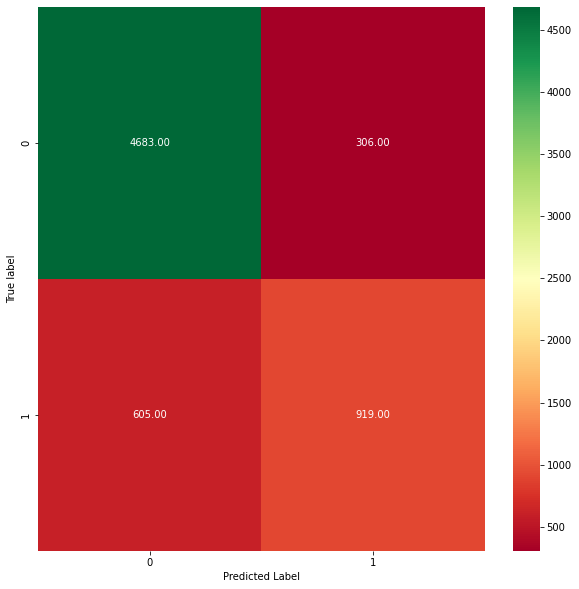

In [75]:
plot_cm(y_test,y_pred)

In [76]:
print("Precision: ", precision_score(y_test,y_pred))  
print("Recall:", recall_score(y_test,y_pred))
print("F1 Score:", f1_score(y_test,y_pred))

Precision:  0.7502040816326531
Recall: 0.6030183727034121
F1 Score: 0.6686067660967625
